In [85]:
from scipy.io import arff
import pandas as pd
import numpy as np
import pydantic
import copy
import matplotlib.pyplot as plt
from typing import Union, Any

from pydantic import BaseModel, Field
from typing import List, Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, StandardScaler
from sklearn import datasets

In [2]:
# compute metric

def if_empty_zero(array: np.array) -> np.array:
    if array.size == 0:
        array = 0

    return np.array(array)


def compute_variance_contribution(cov: np.array, comp: np.array, k: int, l: int, d: int) -> float:

    first_term = comp[k, l] ** 2 * cov[l, l]

    f1 = comp[k, :l] * comp[k, l] * cov[:l, l]
    f2 = comp[k, l+1:d] * comp[k, l] * cov[l+1:d, l]

    second_term = np.sum(if_empty_zero(f1)) + np.sum(if_empty_zero(f2))
    contribution = first_term + second_term

    return contribution


def get_contribs(cov: np.array, comp: int, p: int) -> np.array:
    arr_contrib = [[] for _ in range(p)]

    for pc_num in range(p):
        for feature_num in range(p):
            contrib = compute_variance_contribution(cov, comp, pc_num, feature_num, p)
            arr_contrib[pc_num].append(contrib)

    return np.array(arr_contrib)


def get_pca(data: np.array) -> tuple[PCA, np.array]:

    data = scale(data, axis=0)
    pca = PCA(n_components=data.shape[1])
    
    pca.fit(data)
    pca_transformed_data = pca.transform(data)

    return pca, pca_transformed_data


def compute_fitness(data_transformed: np.array,
                    training_mode: bool = True,
                    partial_contribution_objective: bool = False,
                    k: int = 1) -> Union[list, Any]:

    data_transformed = scale(data_transformed, axis=0)

    pca_model, pca_transformed_data = get_pca(copy.deepcopy(data_transformed))
    p = data_transformed.shape[1]
    cov_matrix = np.cov(np.transpose(data_transformed))

    variance_contrib = get_contribs(cov_matrix, pca_model.components_, p)

    if partial_contribution_objective:
        score = np.sum(variance_contrib[:k], axis=0)
    else:
        score = [np.sum(variance_contrib[:k])]*p

    return score, pca_transformed_data


# preprocess data

In [3]:
def get_split_indices(data: np.array, random_seed: int, val_prop: float = 0.2) -> Tuple[np.array, np.array]:
    np.random.seed(random_seed)
    n = data.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    train_indices = indices[int(n * val_prop):]
    val_indices = indices[:int(n * val_prop)]

    return train_indices, val_indices

In [29]:
def preprocess_data(data: pd.DataFrame, dataset: str):

    if dataset in ["phoneme", "breast_cancer"]:
        type_class = data["Class"]

    elif dataset == "abalone":
        type_class = data["sex"]

    elif dataset in ["wine", "ionosphere", "german_credit", "dermatology", "heart-statlog"]:
        type_class = data["class"]

    print("the number of classes is:", len(np.unique(type_class)))

    return data, type_class

In [17]:
def compute_explained_variance(data: np.array, pca_model: PCA):
    
    cov_matrix = np.cov(np.transpose(data))
    explained_var = np.matmul(np.matmul(pca_model.components_, cov_matrix), np.transpose(pca_model.components_))
    explained_var_ratio = np.diag(explained_var) / np.sum(np.diag(explained_var))

    return explained_var_ratio

In [18]:
def read_arff(path):
    data, meta = arff.loadarff(path)
    data = pd.DataFrame(data)
    return data

# perform the variance contrib on data

In [72]:
dataset = "wine"

In [73]:
path = f"../datasets/{dataset}.arff"

In [74]:
data = read_arff(path)
data = data.dropna()

In [75]:
data.shape

(178, 14)

In [76]:
data, type_class = preprocess_data(data, dataset)

the number of classes is: 3


In [77]:
type_class, mapping = pd.factorize(type_class)

In [78]:
print(data.shape, data.columns)

(178, 14) Index(['class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue',
       'OD280%2FOD315_of_diluted_wines', 'Proline'],
      dtype='object')


In [79]:
# Apply factorize on all object columns and replace them in the DataFrame
for col in data.select_dtypes(include=['object']).columns:
    data[col], _ = pd.factorize(data[col])

In [27]:
data

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,0,6.0,0,0,1169.0,0,0,4.0,0,0,...,0,67.0,0,0,2.0,0,1.0,0,0,0
1,1,48.0,1,0,5951.0,1,1,2.0,1,0,...,0,22.0,0,0,1.0,0,1.0,1,0,1
2,2,12.0,0,1,2096.0,1,2,2.0,0,0,...,0,49.0,0,0,1.0,1,2.0,1,0,0
3,0,42.0,1,2,7882.0,1,2,2.0,0,1,...,1,45.0,0,1,1.0,0,2.0,1,0,0
4,0,24.0,2,3,4870.0,1,1,3.0,0,0,...,2,53.0,0,1,2.0,0,2.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,12.0,1,2,1736.0,1,2,3.0,1,0,...,0,31.0,0,0,1.0,1,1.0,1,0,0
996,0,30.0,1,4,3857.0,1,1,4.0,2,0,...,1,40.0,0,0,1.0,2,1.0,0,0,0
997,2,12.0,1,0,804.0,1,0,4.0,0,0,...,3,38.0,0,0,1.0,0,1.0,1,0,0
998,0,45.0,1,0,1845.0,1,1,4.0,0,0,...,2,23.0,0,1,1.0,0,1.0,0,0,1


In [326]:
data_numerical = scale(data, axis=0)

train_indices, val_indices = get_split_indices(data_numerical, 0)
train_x, val_x = np.array(data.iloc[train_indices]), np.array(data.iloc[val_indices])
train_class, val_class = type_class[train_indices], type_class[val_indices]

print(train_x.shape, val_x.shape)

(3342, 9) (835, 9)


In [327]:
# print(np.array(compute_fitness(data_numerical, k=1)[0])/data_numerical.shape[1])

In [328]:
pca = PCA()
pca.fit(train_x)

x_pca_train = pca.transform(train_x)
print("explained variance for training data", pca.explained_variance_ratio_)

x_pca_val = pca.transform(val_x)
explained_variance_ratio = compute_explained_variance(val_x, pca)
print("explained variance for validation data", explained_variance_ratio)

explained variance for training data [9.25795592e-01 5.57682561e-02 1.77390744e-02 2.66542030e-04
 2.33778799e-04 9.48545188e-05 4.95709229e-05 3.91777519e-05
 1.31533477e-05]
explained variance for validation data [9.29313535e-01 5.46282722e-02 1.54650289e-02 2.55037889e-04
 2.02659184e-04 8.03230404e-05 1.62526435e-05 2.70150213e-05
 1.18761775e-05]


In [329]:
print("explained variance for validation data", explained_variance_ratio*val_x.shape[1])

explained variance for validation data [8.36382181e+00 4.91654449e-01 1.39185260e-01 2.29534100e-03
 1.82393266e-03 7.22907364e-04 1.46273792e-04 2.43135192e-04
 1.06885597e-04]


In [334]:
mapping

Index([b'M', b'F', b'I'], dtype='object')

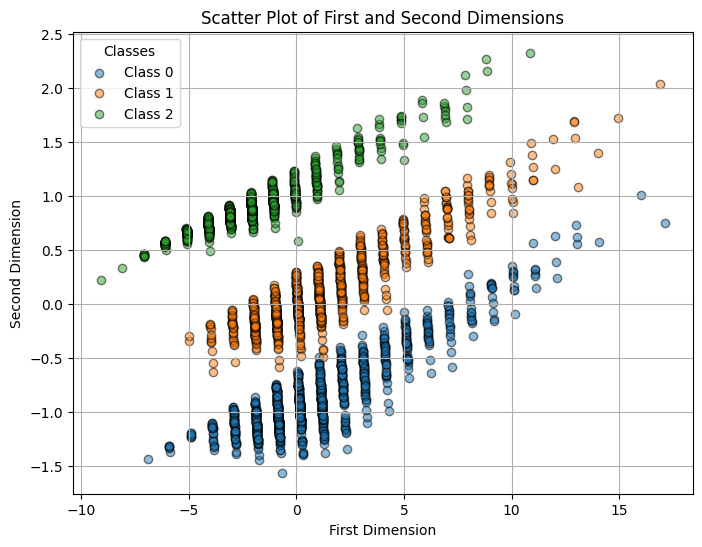

In [332]:
# Define unique classes and corresponding colors
unique_classes = np.unique(train_class)
colors = plt.cm.tab10(unique_classes)  # Use a colormap to assign colors

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot each class separately to create a legend
for cls, color in zip(unique_classes, colors):
    plt.scatter(
        x_pca_train[train_class == cls, 0], 
        x_pca_train[train_class == cls, 1], 
        alpha=0.5, edgecolor="k", c=[color], 
        label=f'Class {cls}'
    )

plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Scatter Plot of First and Second Dimensions')
plt.legend(title='Classes')
plt.show()

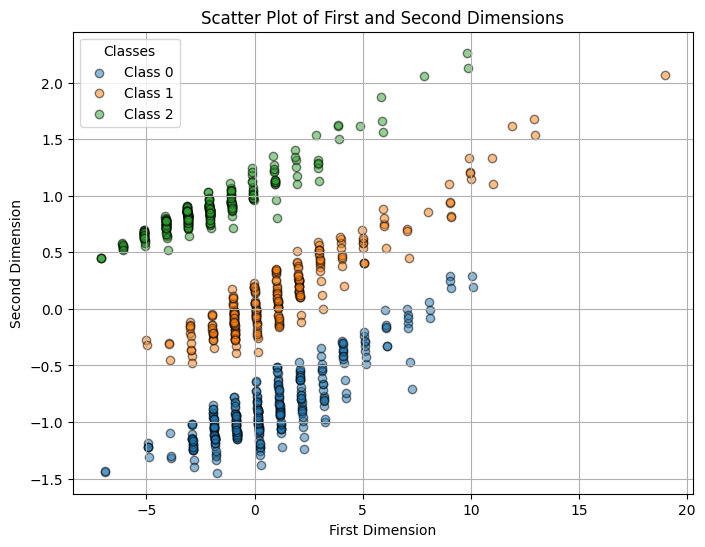

In [333]:
# Define unique classes and corresponding colors
unique_classes = np.unique(val_class)
colors = plt.cm.tab10(unique_classes)  # Use a colormap to assign colors

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot each class separately to create a legend
for cls, color in zip(unique_classes, colors):
    plt.scatter(
        x_pca_val[val_class == cls, 0], 
        x_pca_val[val_class == cls, 1], 
        alpha=0.5, edgecolor="k", c=[color], 
        label=f'Class {cls}'
    )

plt.xlabel('First Dimension')
plt.ylabel('Second Dimension')
plt.title('Scatter Plot of First and Second Dimensions')
plt.legend(title='Classes')
plt.show()

# PCA's biplot

In [115]:
def create_enhanced_biplot(pca: PCA, data: np.array, target: np.array, original_column_names: list[str]):
    
    # Create the plot with improved aesthetics
    plt.figure(figsize=(10, 8))
    
    # Discrete color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Scatter plot of data points with discrete colors
    for i in range(len(np.unique(target))):
        mask = target == i
        plt.scatter(data[mask, 0], data[mask, 1], 
                    color=colors[i], 
                    label=f'Class {i}',
                    edgecolor='black', 
                    linewidth=1, 
                    alpha=0.75)
    
    # Variable (feature) arrows
    components = pca.components_[0:2, :]
    for i, feature in enumerate(original_column_names):
        # Straight arrows
        plt.arrow(0, 0, components[0, i], components[1, i], 
                  color='red', 
                  head_width=0.05, 
                  head_length=0.1, 
                  alpha=0.7)
        
        # Add feature labels with slight offset
        plt.text(components[0, i]*1.2, 
                 components[1, i]*1.2, 
                 feature, 
                 color='darkred', 
                 ha='center', 
                 va='center', 
                 fontweight='bold',
                 fontsize=12)
    
    # Styling
    plt.title('PCA Biplot of Iris Dataset', fontsize=15)
    plt.xlabel(f'First Principal Component (Variance Explained: {pca.explained_variance_ratio_[0]*100:.2f}%)', fontsize=12)
    plt.ylabel(f'Second Principal Component (Variance Explained: {pca.explained_variance_ratio_[1]*100:.2f}%)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axis('equal')
    
    # Add discrete legend
    plt.legend(fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [116]:
# Load Iris dataset
iris = datasets.load_iris()
data_x = iris.data

scaler = StandardScaler()
data_x = scaler.fit_transform(data_x)

pca = PCA()
data_x = pca.fit_transform(data_x)

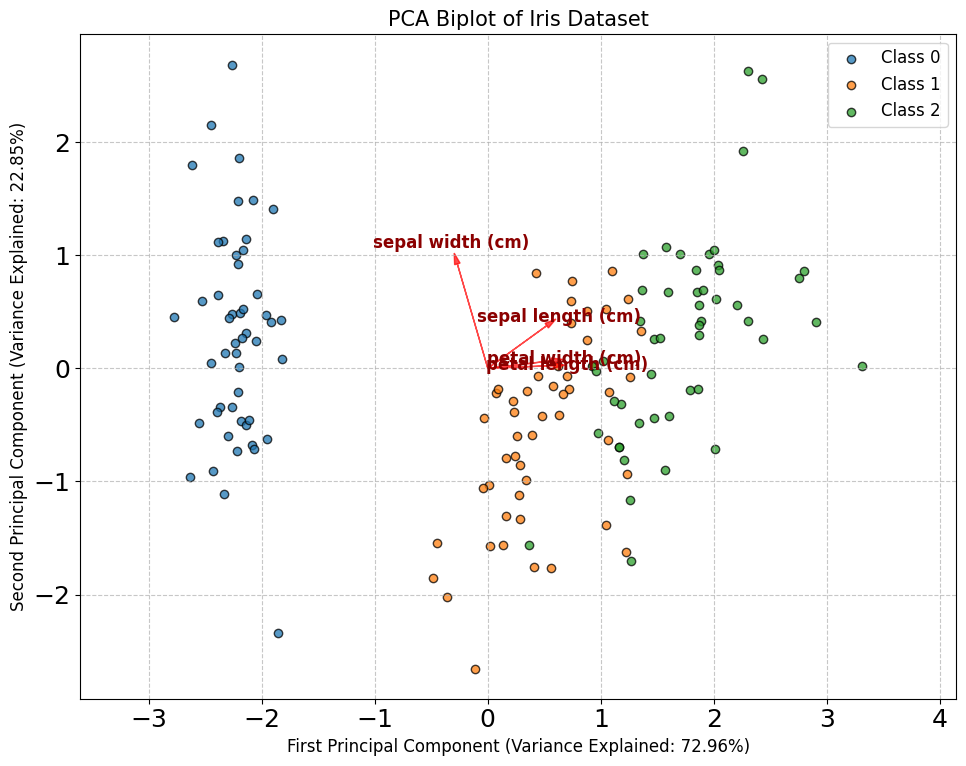

In [117]:
create_enhanced_biplot(pca, data_x, iris.target, iris.feature_names)